In [120]:
import timeit
import pandas as pd
import os
import numpy as np

In [121]:
movies_file = 'data/ml-10M100K/movies.dat'
ratings_file = 'data/ml-10M100K/ratings.dat'


# set static variables
_pickle_dir = os.path.join(os.path.dirname(
    os.path.abspath('eda2.ipynb')), 'data\pickled')

# set appropriate paths for pickle files
_ratings_pickle_filename = 'movie_ratings.pkl'
ratings_pickle_path = os.path.join(_pickle_dir, _ratings_pickle_filename)
_movies_pickle_filename = 'movies.pkl'
movies_pickle_path = os.path.join(_pickle_dir, _movies_pickle_filename)

# try to load from pickle if available
try:
    # load movies df from pickle if it exists
    if os.path.exists(movies_pickle_path):
        movies_df = pd.read_pickle(movies_pickle_path)
    else :
        movies_df = pd.read_csv(movies_file, engine='python', encoding='utf-8',
                                        sep='::', header=None, names=['movie_id', 'name', 'genres'],
                                        index_col='movie_id', dtype={'movie_id': np.int32, 'name': np.chararray, 'genres': np.chararray})

    # load ratings df from pickle if it exists
    if os.path.exists(ratings_pickle_path):
        ratings_df = pd.read_pickle(ratings_pickle_path)
    else:
        ratings_df = pd.read_csv(ratings_file, engine='python', encoding='utf-8',
                                        sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'],
                                        index_col='movie_id', dtype={'user_id': np.int32, 'movie_id': np.int32, 'rating': np.int32, 'timestamp': np.float64})
# catch exceptions
except Exception as e:
    print(e)


                      name                                       genres  year  \
movie_id                                                                        
1         Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy  1995   
1         Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy  1995   
1         Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy  1995   
1         Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy  1995   
1         Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy  1995   

          user_id  rating     timestamp  
movie_id                                 
1               5       1  8.579113e+08  
1              14       3  1.133572e+09  
1              18       3  1.111546e+09  
1              23       5  8.495435e+08  
1              24       5  8.682542e+08  


Text(0, 0.5, 'Frequency')

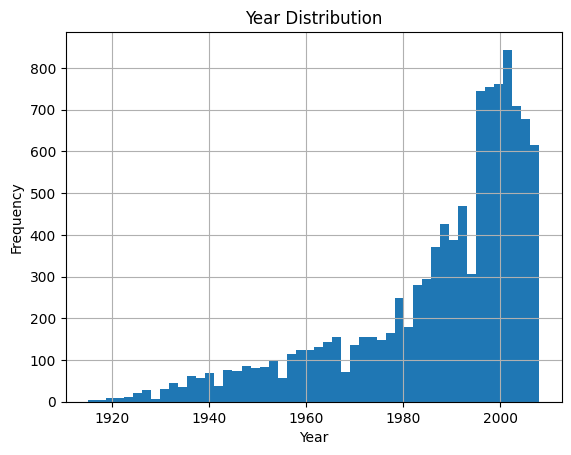

In [122]:
import re
import matplotlib.pyplot as plt

def extract_year(name):
    pattern = r'\((\d{4})\)'
    match = re.search(pattern, name)
    if match:
        return int(match.group(1))
    else:
        return None

movies_df['year'] = movies_df['name'].apply(extract_year)
stats_df = pd.merge(movies_df, ratings_df, how='inner', on='movie_id')
print(stats_df.head())

years = movies_df['year'].values

pd.Series(years).hist(bins=50)

# set the plot title and axis labels
plt.title('Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')

# show the plot
# plt.show()


In [124]:
# drop indexes from movies_df
movies_df.reset_index(inplace=True)
ratings_df.reset_index(inplace=True)

# merge dataframes using inner join
merged_df = pd.merge(ratings_df, movies_df, how="inner", on="movie_id")
merged_df.head()

# make a set of movie_id where movie has Children genre
children_movie_ids = set(merged_df.loc[merged_df['genres'].str.contains('Children', na=False), 'movie_id'])
print(children_movie_ids)

# drop unnecessary columns for performance
merged_df.drop(['timestamp', 'genres'], axis=1, inplace=True)

merged_df = merged_df.groupby(
    by=['movie_id', 'user_id'], as_index=False).agg({"rating": "mean"})

merged_df = merged_df.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)

print(merged_df.shape)


{2048, 1, 2, 2050, 2051, 2052, 2054, 2053, 8, 2057, 2056, 2059, 13, 6158, 45074, 2039, 47124, 6169, 6170, 2077, 2078, 8221, 2080, 2081, 34, 2082, 2083, 2085, 26662, 2087, 2042, 2089, 2090, 2091, 2092, 2093, 2095, 48, 2097, 2096, 2099, 2098, 63540, 54, 2102, 2103, 56, 4154, 60, 2116, 30793, 2123, 80, 87, 6232, 2137, 2138, 2139, 2140, 2141, 2142, 4188, 2152, 6251, 107, 59501, 2161, 2162, 6259, 49274, 126, 4232, 4241, 146, 45208, 6297, 158, 47264, 8360, 169, 26792, 6316, 8368, 8372, 181, 6332, 6338, 61634, 4294, 26828, 6350, 4306, 53460, 2079, 6371, 8423, 6377, 238, 239, 241, 244, 2294, 2084, 6391, 250, 258, 6405, 262, 4366, 6414, 6427, 4386, 8487, 2354, 2355, 31030, 313, 314, 8525, 2384, 6173, 6485, 8534, 343, 8537, 2399, 2400, 355, 362, 364, 63859, 33140, 374, 45431, 8572, 2430, 8574, 59784, 6536, 39307, 2449, 47516, 6557, 6559, 8224, 8612, 421, 6566, 4519, 8616, 455, 45517, 31193, 50162, 6624, 6625, 484, 49642, 49647, 51698, 502, 31223, 2559, 2566, 8713, 531, 47642, 546, 551, 43560, 55

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

sparse_item_df = csr_matrix(merged_df.values)
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_item_df)

for i in range(0,10):
    weights, neighbors = model.kneighbors([merged_df.iloc[i]], n_neighbors=50)
    neighbors = neighbors[0]
    for idx, n in enumerate(neighbors[1:4]):
        print(movies_df.iloc[i]['name'], movies_df.iloc[n]['name'], weights[0][idx])

